In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("./archive (4)/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [2]:
import os
import librosa
import librosa.display

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [4]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [5]:
# Audio Playback (Optional)
import IPython.display as ipd

from tqdm.auto import tqdm

In [6]:
dat1, sampling_rate1 = librosa.load('./archive (4)/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('./archive (4)/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

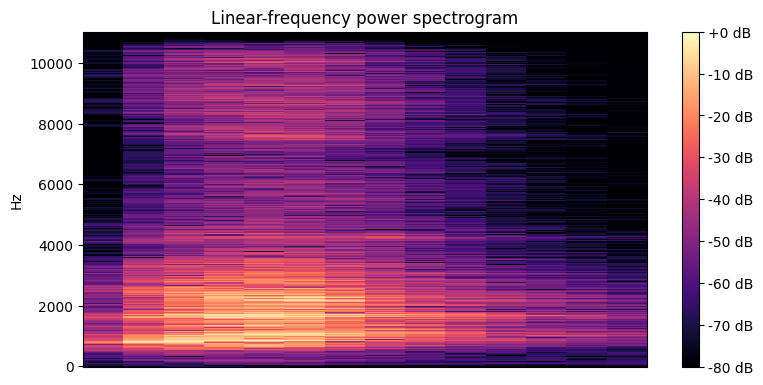

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Register Matplotlib Converters for Time Series Plots
pd.plotting.register_matplotlib_converters()
%matplotlib inline  
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

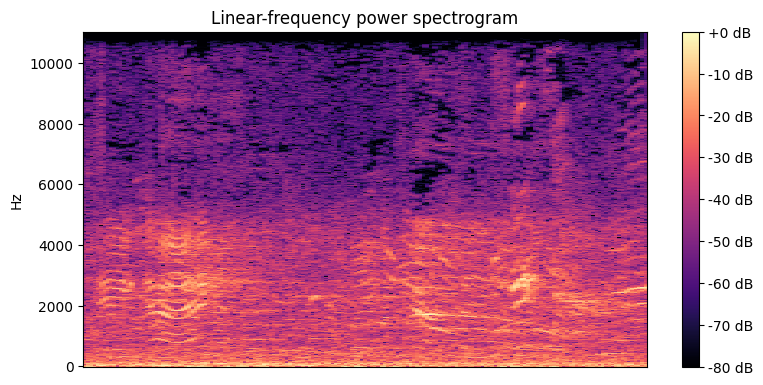

In [8]:
plt.figure(figsize=(20, 20))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

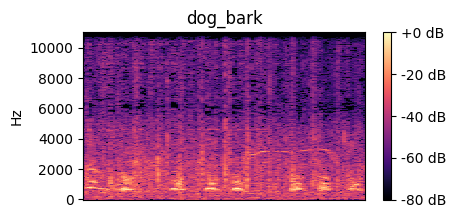

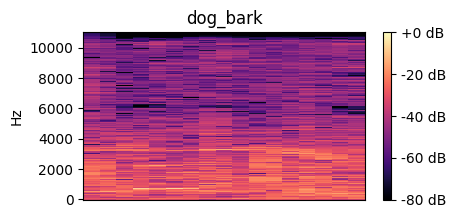

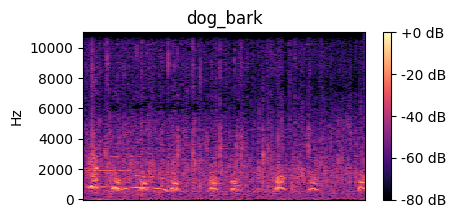

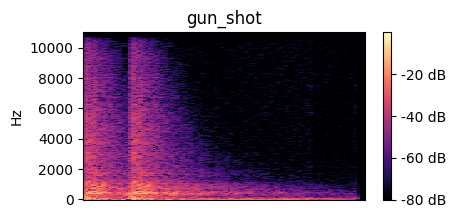

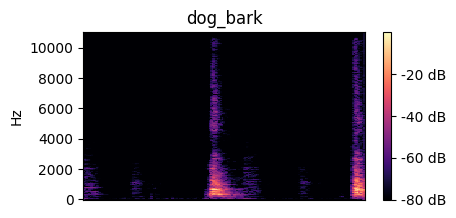

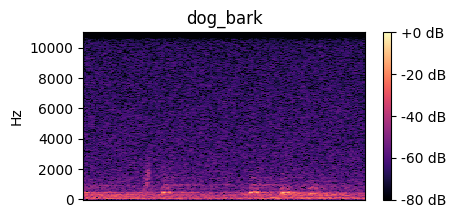

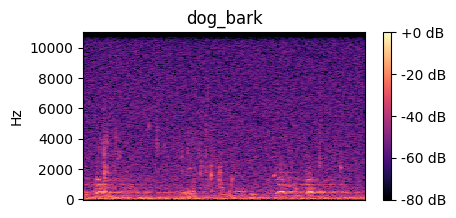

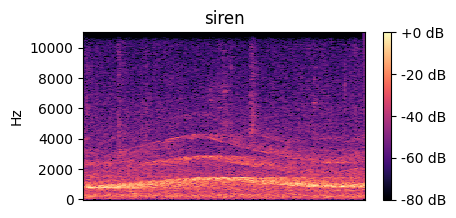

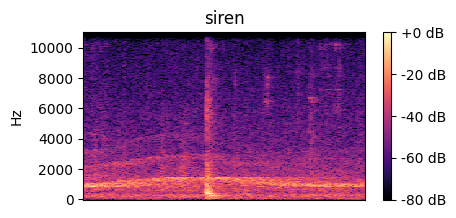

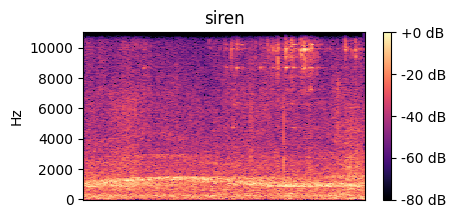

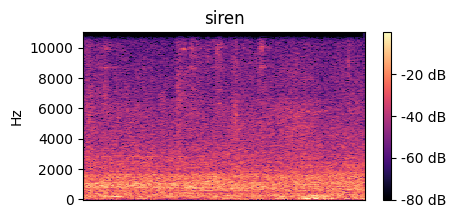

In [9]:
arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(100, 121, 2):
    path = './archive (4)/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 10))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

In [11]:
# First restart kernel 
print("Librosa version:", librosa.__version__)

Librosa version: 0.10.2.post1


In [12]:
def features_extract(file_name):
    sample, sample_rate = librosa.load(file_name, sr=None)  # Avoid resampling
    feature = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=50, n_fft=1024)
    scaled_feature = np.mean(feature.T, axis=0)
    return scaled_feature

extracted = []
path = './archive (4)'

for index_num, row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(path), 'fold' + str(row["fold"]), str(row['slice_file_name'])) 
    final_class_labels = row['class']   
    data = features_extract(file_name)    
    extracted.append([data, final_class_labels])


0it [00:00, ?it/s]

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [13]:
ext_df = pd.DataFrame(extracted,columns=['feature','class'])
ext_df

,feature,class
0,"[-351.31757, 117.981636, -95.81988, -65.53432,...",dog_bark
1,"[-573.2332, 183.8388, -86.40056, 48.547085, 9....",children_playing
2,"[-604.575, 186.74057, -71.29498, 40.730904, 8....",children_playing
3,"[-548.593, 160.9375, -62.202946, 50.249115, 0....",children_playing
4,"[-594.21716, 183.91356, -82.14957, 45.883015, ...",children_playing
...,...,...
8727,"[-538.649, 191.99374, -64.07638, 29.174511, -9...",car_horn
8728,"[-468.83472, 132.39731, -63.712795, 41.505905,...",car_horn
8729,"[-434.77618, 167.4113, -62.00018, 30.774382, -...",car_horn
8730,"[-476.32877, 178.94542, -63.6594, 25.602303, -...",car_horn


In [14]:
x = np.array(ext_df['feature'].tolist())
y = np.array(ext_df['class'].tolist())
le = LabelEncoder()

y = to_categorical(le.fit_transform(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Number of training samples = ", x_train.shape[0])
print("Number of testing samples = ",x_test.shape[0])

Number of training samples =  6985
Number of testing samples =  1747


In [15]:
from tensorflow.keras.layers import Input

num_labels = y.shape[1]
model = Sequential([
    Input(shape=(50,)),  
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'), 

    Dense(num_labels, activation='softmax')  
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,530 (545.04 KB)

 Trainable params: 139,530 (545.04 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
history = model.fit(
          x_train, 
          y_train, 
          batch_size=32, 
          epochs=100,
          validation_data=(x_test, y_test),
         )

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1192 - loss: 17.1894 - val_accuracy: 0.1408 - val_loss: 2.2770
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1323 - loss: 2.7242 - val_accuracy: 0.1631 - val_loss: 2.2615
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1649 - loss: 2.3552 - val_accuracy: 0.1843 - val_loss: 2.2066
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1733 - loss: 2.2429 - val_accuracy: 0.2112 - val_loss: 2.1361
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2087 - loss: 2.1391 - val_accuracy: 0.2833 - val_loss: 2.0104
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2317 - loss: 2.0624 - val_accuracy: 0.3223 - val_loss: 1.9411
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2802 - loss: 1.9701 - val_accuracy: 0.3927 - val_loss: 1.7770
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3030 - loss: 1.8788 - val_acc

In [18]:
def showAccVallLossPlt(history):
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

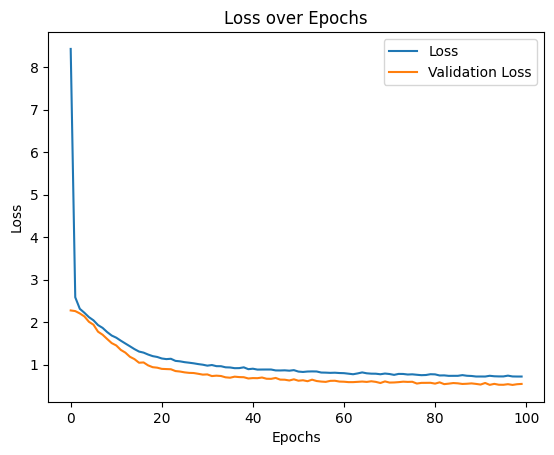

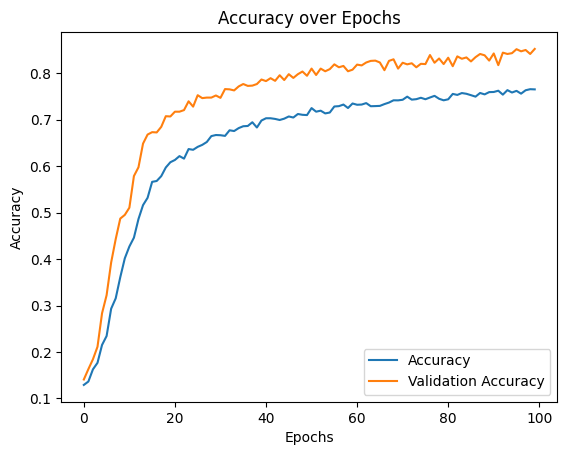

In [19]:
showAccVallLossPlt(history)

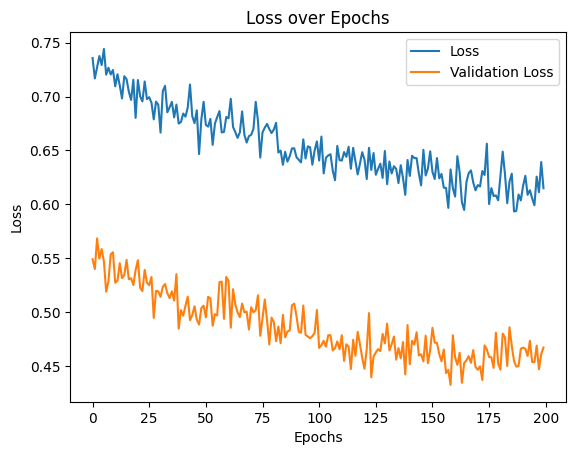

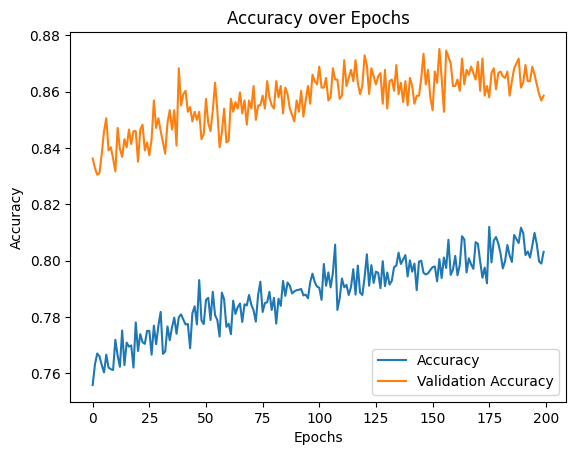

In [32]:
showAccVallLossPlt(history2)

Epoch 1/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7581 - loss: 0.7163 - val_accuracy: 0.8563 - val_loss: 0.5097
Epoch 2/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7736 - loss: 0.6596 - val_accuracy: 0.8598 - val_loss: 0.4947
Epoch 3/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7755 - loss: 0.6883 - val_accuracy: 0.8592 - val_loss: 0.4972
Epoch 4/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7891 - loss: 0.6395 - val_accuracy: 0.8563 - val_loss: 0.5028
Epoch 5/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7895 - loss: 0.6359 - val_accuracy: 0.8540 - val_loss: 0.5065
Epoch 6/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7865 - loss: 0.6666 - val_accuracy: 0.8500 - val_loss: 0.4967
Epoch 7/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7757 - loss: 0.6578 - val_accuracy: 0.8552 - val_loss: 0.4960
Epoch 8/180
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7930 - loss: 0.6174 - val_accu

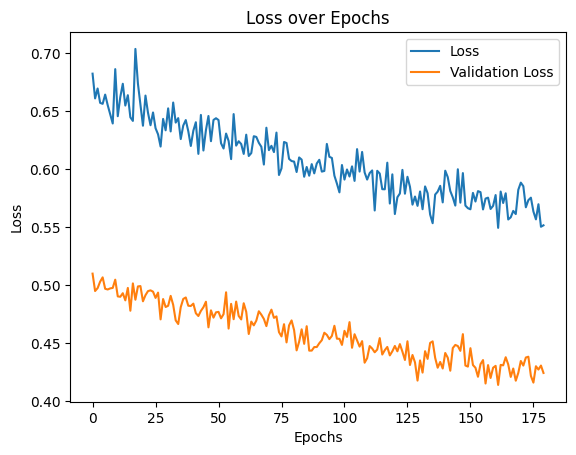

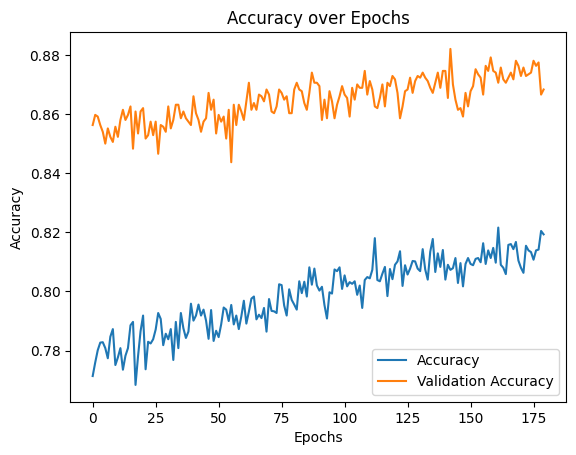

In [20]:
history3 = model.fit(
          x_train, 
          y_train, 
          batch_size=64, 
          epochs=180,
          validation_data=(x_test, y_test),
         )
showAccVallLossPlt(history3)

CNN

In [21]:
def extract_feature(file_name):
    audio_data, sample_rate = librosa.load(file_name, sr=22050, res_type='soxr_vhq')  # Avoids resampy
    fea = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
    scaled = np.mean(fea.T, axis=0)
    return np.array([scaled])

def print_prediction(file_name):
    pred_fea = extract_feature(file_name) 
    pred_vector = np.argmax(model.predict(pred_fea), axis=-1)
    pred_class = le.inverse_transform(pred_vector)
    print("The predicted class is:", pred_class[0], '\n') 

In [22]:
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [23]:
print_prediction('./archive (4)/fold1/101415-3-0-3.wav')
ipd.Audio('./archive (4)/fold1/101415-3-0-3.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
The predicted class is: dog_bark 



In [24]:
print_prediction('./archive (4)/fold10/100648-1-2-0.wav')
ipd.Audio('./archive (4)/fold10/100648-1-2-0.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The predicted class is: street_music 



In [26]:
class_labels = [
    "Air Conditioner",  # 0
    "Car Horn",         # 1
    "Children Playing", # 2
    "Dog Bark",         # 3
    "Drilling",         # 4
    "Engine Idling",    # 5
    "Gun Shot",         # 6
    "Jackhammer",       # 7
    "Siren",            # 8
    "Street Music"      # 9
]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


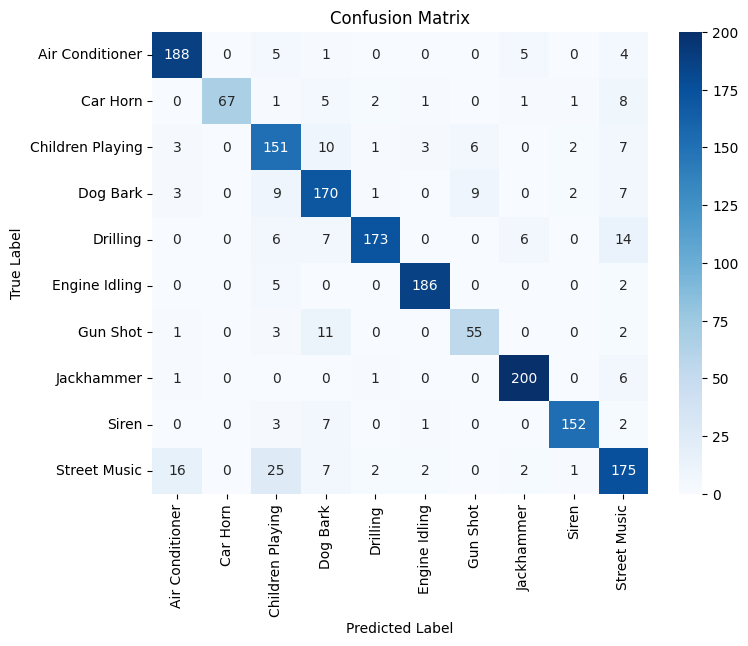

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       203
           1       1.00      0.78      0.88        86
           2       0.73      0.83      0.77       183
           3       0.78      0.85      0.81       201
           4       0.96      0.84      0.90       206
           5       0.96      0.96      0.96       193
           6       0.79      0.76      0.77        72
           7       0.93      0.96      0.95       208
           8       0.96      0.92      0.94       165
           9       0.77      0.76      0.77       230

    accuracy                           0.87      1747
   macro avg       0.88      0.86      0.87      1747
weighted avg       0.87      0.87      0.87      1747



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred_probs = model.predict(x_test)  
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded

# Step 3: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))


In [28]:
# Overall Accuracy
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, and F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print("Classification Report:\n", report)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
Accuracy: 0.8683
Classification Report:
                   precision    recall  f1-score   support

 Air Conditioner       0.89      0.93      0.91       203
        Car Horn       1.00      0.78      0.88        86
Children Playing       0.73      0.83      0.77       183
        Dog Bark       0.78      0.85      0.81       201
        Drilling       0.96      0.84      0.90       206
   Engine Idling       0.96      0.96      0.96       193
        Gun Shot       0.79      0.76      0.77        72
      Jackhammer       0.93      0.96      0.95       208
           Siren       0.96      0.92      0.94       165
    Street Music       0.77      0.76      0.77       230

        accuracy                           0.87      1747
       macro avg       0.88      0.86      0.87      1747
    weighted avg       0.87      0.87      0.87      1747

